# First try of LSTM on APPL

## Installing and importing libraries

In [209]:
!pip3 install yfinance
!pip3 install pandas
!pip3 install matplotlib
!pip3 install scikit-learn
!pip3 install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [210]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from IPython.display import display
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers


## Try the yfinance api and plot it

In [211]:
ticker_symbol = 'AAPL'
stock_data = yf.download(ticker_symbol, period="365d")

[*********************100%***********************]  1 of 1 completed


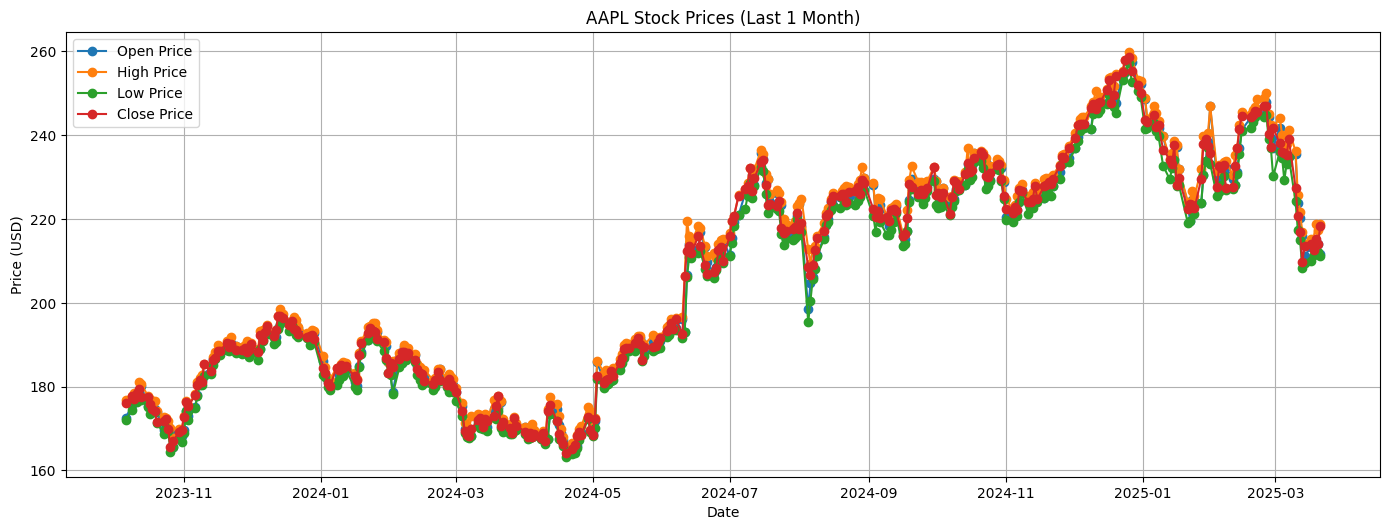

In [212]:
plt.figure(figsize=(14, 10))

plt.subplot(2, 1, 1)
plt.plot(stock_data['Open'], label='Open Price', marker='o')
plt.plot(stock_data['High'], label='High Price', marker='o')
plt.plot(stock_data['Low'], label='Low Price', marker='o')
plt.plot(stock_data['Close'], label='Close Price', marker='o')
plt.title(f'{ticker_symbol} Stock Prices (Last 1 Month)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [213]:
stock_data.tail()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2025-03-17,214.000000,215.220001,209.970001,213.309998,48073400
2025-03-18,212.690002,215.149994,211.490005,214.160004,42432400
2025-03-19,215.240005,218.759995,213.750000,214.220001,54385400
2025-03-20,214.100006,217.490005,212.220001,213.990005,48862900
2025-03-21,218.270004,218.839996,211.279999,211.559998,93954500


## LSTM Model

I am using an LSTM (long short term memory) Neural Network in order to predict stock market data using past days closing prize.

### Preparing data with time windows

In [214]:
def win(stock_data, window):
    close = stock_data['Close']
    windowed_closing_values = []
    
    for i in range(len(close)):
        labels = []
        labels.append(stock_data.index[i])
        for j in range(window + 1):
            if i - j >= 0: 
                labels.append(close.values[i - (-j + window)])
            else:
                labels.append(None)
        windowed_closing_values.append(labels)

    windowed_closing_values = pd.DataFrame(windowed_closing_values)
    windowed_closing_values.drop(windowed_closing_values.index[:window], inplace=True)

    labels = ["-" + str(window -i) + "d" for i in range(window)]
    labels = ["Label Date"] + labels + ["Label"]

    windowed_closing_values.columns = labels
    return windowed_closing_values


In [215]:
windowed_closing_values = win(stock_data, 3)
display(windowed_closing_values)

,Label Date,-3d,-2d,-1d,Label
3,2023-10-11,[176.19859313964844],[177.6876983642578],[177.09207153320312],[178.49179077148438]
4,2023-10-12,[177.6876983642578],[177.09207153320312],[178.49179077148438],[179.3951873779297]
5,2023-10-13,[177.09207153320312],[178.49179077148438],[179.3951873779297],[177.54872131347656]
6,2023-10-16,[178.49179077148438],[179.3951873779297],[177.54872131347656],[177.41964721679688]
7,2023-10-17,[179.3951873779297],[177.54872131347656],[177.41964721679688],[175.86105346679688]
...,...,...,...,...,...
360,2025-03-17,[216.97999572753906],[209.67999267578125],[213.49000549316406],[214.0]
361,2025-03-18,[209.67999267578125],[213.49000549316406],[214.0],[212.69000244140625]
362,2025-03-19,[213.49000549316406],[214.0],[212.69000244140625],[215.24000549316406]
363,2025-03-20,[214.0],[212.69000244140625],[215.24000549316406],[214.10000610351562]


In [236]:
def date_X_y_split(windowed_closing_values, window):
    dates = windowed_closing_values.iloc[0]

    np_array = windowed_closing_values.iloc[:, 1:].to_numpy(dtype=np.float64)

    dates = windowed_closing_values.iloc[:, 0].to_numpy()

    X = np_array[:, :-1].reshape(len(np_array), window, 1)
    y = np_array[:, -1]
    
    return dates, X, y

In [217]:
dates, X, y = date_X_y_split(windowed_closing_values, 3)
print(X.shape)
print(y.shape)
print(X.dtype)
print(dates.dtype)

(362, 3, 1)
(362,)
float64
datetime64[ns]


### Spliting data

In [218]:
d_80 = int(len(dates) * 0.8)
d_90 = int(len(dates) * 0.9)

dates_train, X_train, y_train = dates[:d_80], X[:d_80], y[:d_80]

dates_val, X_val, y_val = dates[d_80:d_90], X[d_80:d_90], y[d_80:d_90]

dates_test, X_test, y_test = dates[d_90:], X[d_90:], y[d_90:]

### Training the model

In [219]:
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation = 'relu'),
                    layers.Dense(32, activation = 'relu'),
                    layers.Dense(1)])

model.compile(loss='mse', optimizer = Adam(learning_rate=0.001), metrics = ['mean_absolute_error'])
model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 100)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 40730.7578 - mean_absolute_error: 200.5860 - val_loss: 58787.4375 - val_mean_absolute_error: 242.2443
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 40187.5586 - mean_absolute_error: 199.1670 - val_loss: 58553.4023 - val_mean_absolute_error: 241.7607
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 39997.3711 - mean_absolute_error: 198.6922 - val_loss: 58264.5820 - val_mean_absolute_error: 241.1627
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 39325.1641 - mean_absolute_error: 197.0925 - val_loss: 57900.9062 - val_mean_absolute_error: 240.4076
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 39269.1367 - mean_absolute_error: 196.9170 - val_loss: 57436.4062 - val_mean_absolute_error: 239.4395
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 39318.8477 - mean_absolute_error: 196.9482 - val_loss: 56725.8477 - val_mean_absolute_error: 237.9510
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━

### Results

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


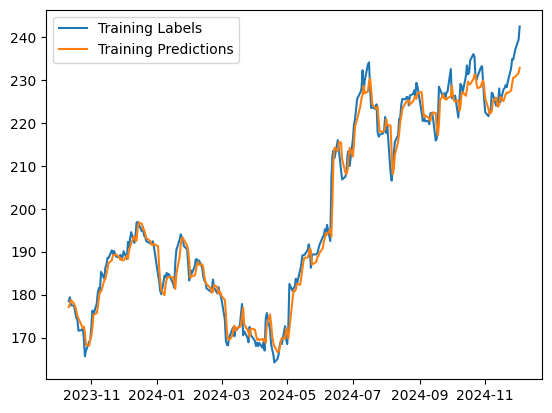

In [220]:
train_predictions = model.predict(X_train).flatten() 

plt.plot(dates_train, y_train)
plt.plot(dates_train, train_predictions)
plt.legend(["Training Labels", "Training Predictions"])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


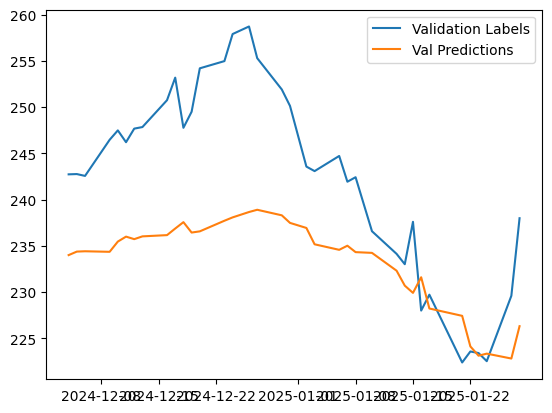

In [221]:
val_predictions = model.predict(X_val).flatten() 

plt.plot(dates_val, y_val)
plt.plot(dates_val, val_predictions)
plt.legend(["Validation Labels", "Val Predictions"])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


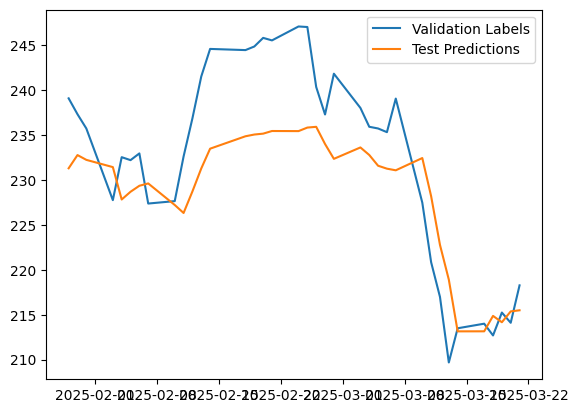

In [222]:
test_predictions = model.predict(X_test).flatten() 

plt.plot(dates_test, y_test)
plt.plot(dates_test, test_predictions)
plt.legend(["Validation Labels", "Test Predictions"])

Although having great results here I come to realize that it's lacking on precision in the exact prize prediction, but it's strong in determining the direction on a stock using past predictions.

I can also vary the length in days of de dataframe hoping this will improve the precision.

Can also modify the window for better results.

### Tests

In [231]:
def train_and_graph(period, window):
    stock_data = yf.download(ticker_symbol, period= period)
    windowed_closing_values = win(stock_data, window)
    
    dates, X, y = date_X_y_split(windowed_closing_values, window)

    d_80 = int(len(dates) * 0.8)
    d_90 = int(len(dates) * 0.9)
    dates_train, X_train, y_train = dates[:d_80], X[:d_80], y[:d_80]
    dates_val, X_val, y_val = dates[d_80:d_90], X[d_80:d_90], y[d_80:d_90]
    dates_test, X_test, y_test = dates[d_90:], X[d_90:], y[d_90:]

    model = Sequential([layers.Input((window, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation = 'relu'),
                    layers.Dense(32, activation = 'relu'),
                    layers.Dense(1)])

    model.compile(loss='mse', optimizer = Adam(learning_rate=0.001), metrics = ['mean_absolute_error'])
    model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 100)

    test_predictions = model.predict(X_test).flatten() 
    plt.plot(dates_test, y_test)
    plt.plot(dates_test, test_predictions)
    plt.legend(["Validation Labels", "Test Predictions"])

#### 5 years 3 windows

[*********************100%***********************]  1 of 1 completed

Epoch 1/100


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 22202.4023 - mean_absolute_error: 145.6918 - val_loss: 39734.8320 - val_mean_absolute_error: 198.0744
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20526.5469 - mean_absolute_error: 140.2018 - val_loss: 35648.3281 - val_mean_absolute_error: 187.4607
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16275.7148 - mean_absolute_error: 123.4988 - val_loss: 21898.1191 - val_mean_absolute_error: 146.2228
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6259.7041 - mean_absolute_error: 72.2673 - val_loss: 5418.8213 - val_mean_absolute_error: 70.0997
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 898.8951 - mean_absolute_error: 24.1084 - val_loss: 2795.7820 - val_mean_absolute_error: 48.3801
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 348.0186 - mean_absolute_error: 14.1898 - val_loss: 1590.2137 - val_mean_absolute_error: 34.1786
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4

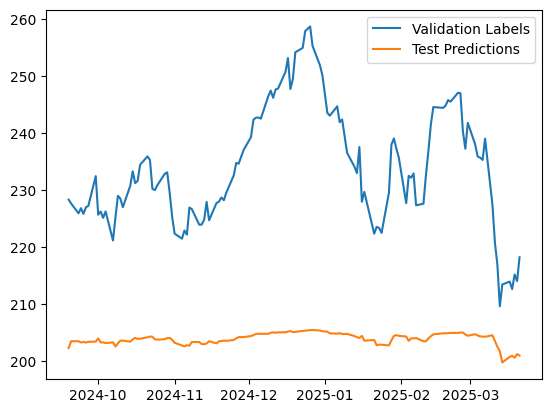

In [232]:
train_and_graph("5y", 3)

#### 100 days 3 windows

[*********************100%***********************]  1 of 1 completed

Epoch 1/100


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 56285.5469 - mean_absolute_error: 237.0118 - val_loss: 57359.8672 - val_mean_absolute_error: 239.4634
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 56087.4648 - mean_absolute_error: 236.6232 - val_loss: 57253.8984 - val_mean_absolute_error: 239.2420
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 56216.3711 - mean_absolute_error: 236.8806 - val_loss: 57180.5195 - val_mean_absolute_error: 239.0886
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 56353.5820 - mean_absolute_error: 237.1899 - val_loss: 57092.1055 - val_mean_absolute_error: 238.9036
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 55832.8242 - mean_absolute_error: 236.0937 - val_loss: 56988.0938 - val_mean_absolute_error: 238.6859
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 55595.9336 - mean_absolute_error: 235.5607 - val_loss: 56865.6562 - val_mean_absolute_error: 238.4292
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - 

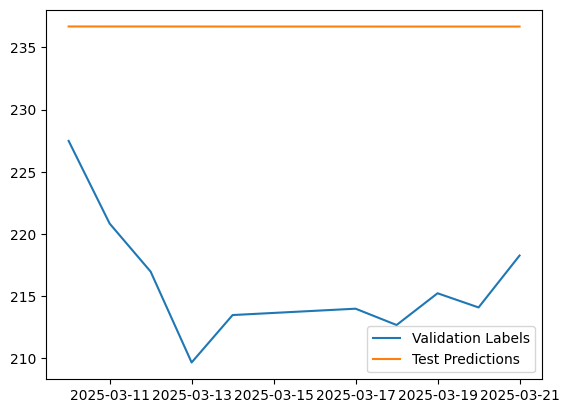

In [233]:
train_and_graph("100d", 3)

#### 200 days 3 windows

[*********************100%***********************]  1 of 1 completed

Epoch 1/100


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 51989.6172 - mean_absolute_error: 227.6881 - val_loss: 55468.5195 - val_mean_absolute_error: 235.4178
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 52116.9922 - mean_absolute_error: 227.9592 - val_loss: 55265.1758 - val_mean_absolute_error: 234.9854
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 51345.6016 - mean_absolute_error: 226.2789 - val_loss: 55025.1016 - val_mean_absolute_error: 234.4740
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 51058.4453 - mean_absolute_error: 225.6544 - val_loss: 54749.5391 - val_mean_absolute_error: 233.8857
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 50996.5703 - mean_absolute_error: 225.5057 - val_loss: 54402.8125 - val_mean_absolute_error: 233.1432
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 50072.9648 - mean_absolute_error: 223.4428 - val_loss: 54000.8555 - val_mean_absolute_error: 232.2796
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 

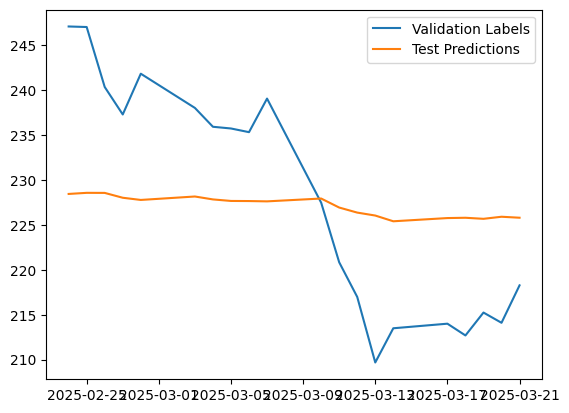

In [234]:
train_and_graph("200d", 3)

#### 365 days 4 windows

[*********************100%***********************]  1 of 1 completed

Epoch 1/100


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 40061.9961 - mean_absolute_error: 198.9346 - val_loss: 58541.2773 - val_mean_absolute_error: 241.7359
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 39436.7539 - mean_absolute_error: 197.3085 - val_loss: 58027.8125 - val_mean_absolute_error: 240.6714
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 39641.4023 - mean_absolute_error: 197.8337 - val_loss: 57323.0547 - val_mean_absolute_error: 239.2024
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 38828.1484 - mean_absolute_error: 195.7583 - val_loss: 56385.5000 - val_mean_absolute_error: 237.2346
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 38228.6172 - mean_absolute_error: 194.2258 - val_loss: 55144.5469 - val_mean_absolute_error: 234.6047
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 37091.3984 - mean_absolute_error: 191.2452 - val_loss: 53593.7969 - val_mean_absolute_error: 231.2762
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 

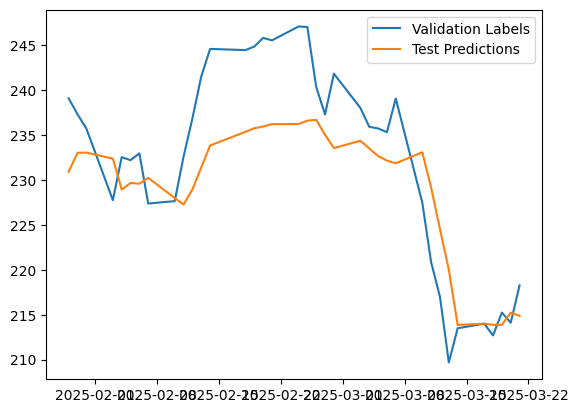

In [237]:
train_and_graph("365d", 4)

#### 365 days 15 windows

[*********************100%***********************]  1 of 1 completed

Epoch 1/100


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 40582.0273 - mean_absolute_error: 200.2285 - val_loss: 58432.5078 - val_mean_absolute_error: 241.5025
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 41141.8164 - mean_absolute_error: 201.5449 - val_loss: 58184.1641 - val_mean_absolute_error: 240.9878
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 40743.4570 - mean_absolute_error: 200.5583 - val_loss: 57890.1602 - val_mean_absolute_error: 240.3770
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 40105.6719 - mean_absolute_error: 198.9827 - val_loss: 57348.6172 - val_mean_absolute_error: 239.2478
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 39660.9102 - mean_absolute_error: 197.8532 - val_loss: 56589.1094 - val_mean_absolute_error: 237.6553
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 39004.2578 - mean_absolute_error: 196.1472 - val_loss: 55754.1484 - val_mean_absolute_error: 235.8921
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 

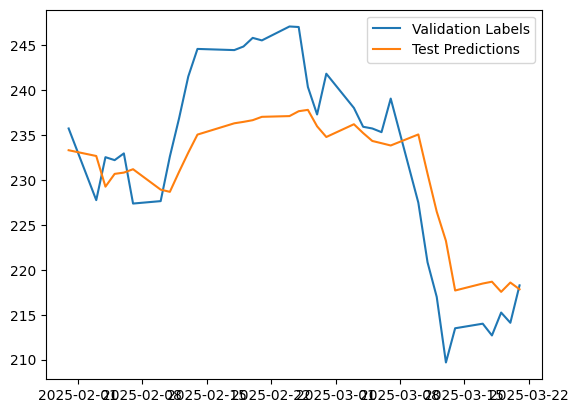

In [239]:
train_and_graph("365d", 15)

#### 365 days 50 windows

[*********************100%***********************]  1 of 1 completed

Epoch 1/100


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 42388.7422 - mean_absolute_error: 204.5046 - val_loss: 57461.5117 - val_mean_absolute_error: 239.4669
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 42402.7070 - mean_absolute_error: 204.5515 - val_loss: 57238.7148 - val_mean_absolute_error: 239.0012
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 42384.9297 - mean_absolute_error: 204.4482 - val_loss: 57049.9102 - val_mean_absolute_error: 238.6060
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 42062.9727 - mean_absolute_error: 203.6557 - val_loss: 56804.9258 - val_mean_absolute_error: 238.0920
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 41500.9336 - mean_absolute_error: 202.3217 - val_loss: 56498.0000 - val_mean_absolute_error: 237.4464
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 41250.3281 - mean_absolute_error: 201.6325 - val_loss: 56067.5117 - val_mean_absolute_error: 236.5383
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - 

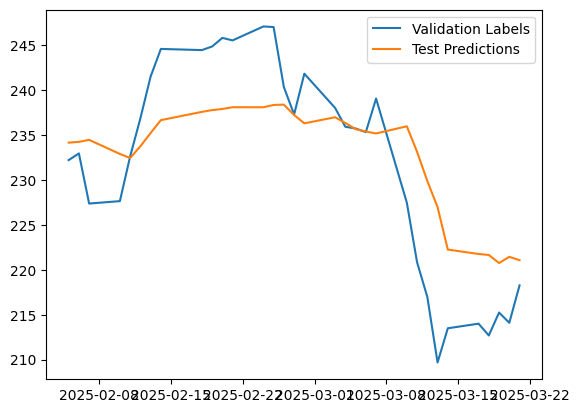

In [240]:
train_and_graph("365d", 50)

#### Resluts

Not quite an upgrade. The best validation mean absolute error is from 365 days and 50 windows, nevertheless I consider it is not a great option due to the windows-days relation. So I think **the best try is for 365 days 15 windows**.